# Data processing

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import multiprocessing
from os import getpid
from scipy import interpolate, optimize as opt, signal
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import time, json, os, glob

In [5]:
CALIBRATED_FREQ = 9983500
START_FREQ = CALIBRATED_FREQ - 10**4
STOP_FREQ = CALIBRATED_FREQ + 10**4
STEP_FREQ = 40
INDEX_OFFSET = 25
freq = lambda m: START_FREQ + STEP_FREQ * m

In [74]:
FORCE_RELOAD_TEXT_FILES = False
if FORCE_RELOAD_TEXT_FILES:
    tic = time.perf_counter()
    files = os.listdir('test_outputs')  # load filenames
    files.sort()
    dataset = [np.genfromtxt('test_outputs/'+f, delimiter=';') for f in files]  # loads files content
    with open('test_outputs.npy', 'wb') as f:
        np.save(f, dataset)
    toc = time.perf_counter()
    print("Took", (toc - tic)*1000, "ms")
    print("Loaded", len(dataset), "samples from text files")
else:
    with open('test_outputs.npy', 'rb') as f:
        dataset = np.load(f)
    print("Loaded", len(dataset), "samples from binary file")

Took 13727.990728999885 ms
Loaded 12468 samples from text files


In [8]:
result = np.array([])  # maximum of measurements
run_only_once = False  # set to true if you want to run only first batch and see plot
for data in dataset[:1000]:  # take first n measurements
    orig_y = data[:-1,1]  # take second column (magnitude) without last row (temp;s)
    max_i = orig_y.argmax()  # find index of maximal magnitude or frequency
    li = max(max_i - INDEX_OFFSET, 0)  # left index boundary for spline (from 0)
    ri = min(max_i + INDEX_OFFSET, len(orig_y) - 1)  # right index boundary for spline (to length of values)
    y = orig_y[li:ri+1]  # take only datapoints near maximum index
    max_x = freq(max_i)  # frequency with maximal magnitude
    x = np.linspace(freq(li), freq(ri), num=len(y))  # frequency range near maximal magnitude
    i = (freq(max_i - 1), freq(max_i + 1))  # index range near maximal magnitude
    f = interpolate.interp1d(x, y, kind='cubic')  # interpolate
    resonance_freq = opt.fmin_l_bfgs_b(lambda x: -f(x), max_x, bounds=[(freq(max_i - 1), freq(max_i + 1))],approx_grad=True)[0][0]  # find maximum of interpolated function
    result = np.append(result, resonance_freq)  # add maximum to the results
    
    if run_only_once:
        break

if run_only_once:
    orig_x = np.linspace(START_FREQ, STOP_FREQ, num=len(orig_y))
    orig_f = interpolate.interp1d(orig_x, orig_y, kind='cubic')
    # only red part is normally interpolated in order to find maximum (we don't need to interpolate the rest)
    # size of the red part can be adjusted by INDEX_OFFSET variable (it represents how many datapoints to take on each side)
    plt.plot(orig_x, orig_f(orig_x), '-', x, f(x), 'r-', [orig_x[ri], orig_x[li]], [orig_y[ri], orig_y[li]], 'ro')
    plt.legend(['measurement', 'interpolated'], loc='best')
    plt.show()

In [17]:
if run_only_once:
    raise RuntimeError("Cannot have run_only_once == True if you want to calculate data")
    
xresult = np.linspace(0, len(result)-1, num=len(result), endpoint=True)  # calc x values
yresult = signal.savgol_filter(result, 201, 5)  # use savitzky-golay filter
# yresult = result

In [18]:
fnew = interpolate.interp1d(xresult, yresult, kind='cubic')  # interpolate array of frequencies with maximal magnitude
xnew = np.linspace(xresult[0], xresult[-1], num=101, endpoint=True)  # recalculate and display fewer values in plot
ynew = fnew(xnew)  # calc y values

<IPython.core.display.Javascript object>


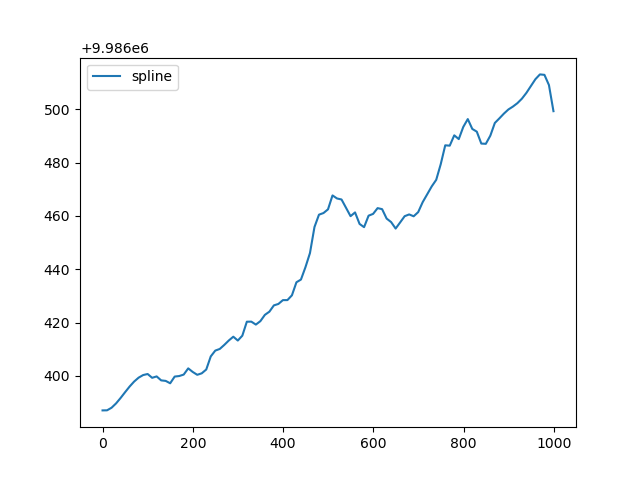

In [19]:
fx = interpolate.interp1d(xnew, ynew, kind='cubic')
xxnew = np.linspace(xresult[0], xresult[-1], num=101, endpoint=True)
plt.plot(xnew, fnew(xnew))
plt.legend(['spline', 'data'], loc='best')
plt.show()
# fx(xxnew)

## Below are functions for parallel computing

### Don't run them or even touch them!!!

In [8]:
def worker(xy):
    for _ in range(4):
        x, y = xy
        f2 = interpolate.interp1d(x, y, kind='cubic')
        xnew = np.linspace(x[0], x[-1], num=101, endpoint=True)
        ynew = f2(xnew)

    return json.dumps([xnew.tolist(), ynew.tolist()])

In [9]:
if __name__ == '__main__':
    x = np.linspace(0, 10, num=3600*50, endpoint=True)
    y = np.cos(-x**2/9.0)
    pool = multiprocessing.Pool(processes = 8)
    
    for _ in range(10):
        tic = time.perf_counter()
        pool.map(worker, [(x, y) for _ in range(8)])
        toc = time.perf_counter()
        print((toc - tic)*1000)


450.67591500082926
407.6856570009113
450.8685559994774
487.13097700056096
423.79811300088477
421.54142200161004
415.684515999601
480.527212999732
507.75163499929477
461.5955170011148
